In [1]:
%matplotlib inline

import h2o
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# constant random seed 
seed = 1234

# Connect to a pre-existing cluster

h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 hours 51 mins
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_jpitt_rbvdxg
H2O cluster total nodes:,1
H2O cluster free memory:,3.071 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [3]:
from h2o.utils.shared_utils import _locate # private function. used to find files within h2o git project directory.

h2o.cluster().show_status()

df = h2o.import_file(path=_locate("train.csv"))


H2O cluster uptime:,2 hours 51 mins
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_jpitt_rbvdxg
H2O cluster total nodes:,1
H2O cluster free memory:,3.233 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
df.describe()

Rows:10885
Cols:13




,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,previouscount
type,time,int,int,int,int,real,real,int,real,int,int,int,int
mins,1293843600000.0,1.0,0.0,0.0,1.0,0.82,0.76,0.0,0.0,0.0,0.0,1.0,1.0
mean,1324968241874.1387,2.5067524115755626,0.02857142857142857,0.6809370693615067,1.4184657785943962,20.2318144235186,23.655934772622874,61.88470372071658,12.800571281580158,36.02498851630684,155.5652733118971,191.59026182820395,191.5836472209463
maxs,1355958000000.0,4.0,1.0,1.0,4.0,41.0,45.455,100.0,56.9969,367.0,886.0,977.0,977.0
sigma,18186077643.01126,1.1161321529674035,0.16660627876431913,0.46613489303567057,0.6338550128938669,7.7913111304392215,8.474525070270193,19.245045237309753,8.163990511234385,49.96176892218166,151.03979036028676,181.14495703238546,181.15005452302242
zeros,0,0,10574,3473,0,0,0,22,1312,986,15,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0
0,2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,8.0,32.0,40.0,16.0
1,2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,5.0,27.0,32.0,40.0
2,2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,3.0,10.0,13.0,32.0


In [5]:
# Does preprocessing on the raw data frame
def preprocess(df):
    df_edited = df
    for field in ["registered", "casual"]:
        try:
            df_edited = df_edited.drop(field)
        except:
            pass

    # Do things with datetime
    # df_edited['datetime'] = df_edited['datetime'].as_date()
    df_edited['dayofweek'] = df_edited['datetime'].dayOfWeek()
    df_edited['dayofmonth'] = df_edited['datetime'].day()
    df_edited['hourofday'] = df_edited['datetime'].hour()
    df_edited['year'] = df_edited['datetime'].year()
    df_edited['month'] = df_edited['datetime'].month()

    # Remove things from frame
    df_edited = df_edited.drop(["datetime"])

    # Convert things to logical factors
    df_edited['holiday'] = df_edited['holiday'].asfactor()
    df_edited['workingday'] = df_edited['workingday'].asfactor()
    df_edited['season'] = df_edited['season'].asfactor()
    df_edited['weather'] = df_edited['weather'].asfactor()
    df_edited['dayofmonth'] = df_edited['dayofmonth'].asfactor()
    df_edited['hourofday'] = df_edited['hourofday'].asfactor()
    df_edited['dayofmonth'] = df_edited['dayofmonth'].asfactor()
    df_edited['month'] = df_edited['month'].asfactor()
    
    return df_edited
    

In [8]:
df_edited = preprocess(df)
train,test,valid = df_edited.split_frame(ratios=[.85, .1], seed = seed)

In [9]:
# See that the data is ready
train.describe()

Rows:9283
Cols:15




,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,previouscount,dayofweek,dayofmonth,hourofday,year,month
type,enum,enum,enum,enum,real,real,int,real,int,int,enum,enum,enum,int,enum
mins,,,,,0.82,0.76,0.0,0.0,1.0,1.0,,,,2011.0,
mean,,,,,20.2193644296025,23.64114725842939,61.81590003231714,12.779464375740602,192.32877302596142,191.93471937951094,,,,2011.5047937089303,
maxs,,,,,41.0,45.455,100.0,56.9969,977.0,977.0,,,,2012.0,
sigma,,,,,7.821605504951305,8.506134753233946,19.226124595547134,8.129678467415845,182.27345686476707,181.77608056277506,,,,0.5000039517137805,
zeros,,,,,0,0,22,1121,0,0,,,,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,0,0,1,9.02,13.635,80.0,0.0,40.0,16.0,Sat,1,1,2011.0,1
1,1,0,0,1,9.02,13.635,80.0,0.0,32.0,40.0,Sat,1,2,2011.0,1
2,1,0,0,1,9.84,14.395,75.0,0.0,13.0,32.0,Sat,1,3,2011.0,1


In [10]:
test.describe()

Rows:1076
Cols:15




,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,previouscount,dayofweek,dayofmonth,hourofday,year,month
type,enum,enum,enum,enum,real,real,int,real,int,int,enum,enum,enum,int,enum
mins,,,,,0.82,2.275,17.0,0.0,1.0,1.0,,,,2011.0,
mean,,,,,20.141059479553903,23.581259293680294,62.094795539033456,12.977084293680297,182.6189591078067,181.7128252788104,,,,2011.486059479554,
maxs,,,,,39.36,43.94,100.0,56.9969,890.0,891.0,,,,2012.0,
sigma,,,,,7.559440165822132,8.235174217310064,19.531449436087325,8.386286152353598,173.54159282494172,176.0668378981466,,,,0.500038037802682,
zeros,,,,,0,0,0,128,0,0,,,,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,0,0,1,15.58,19.695,76.0,16.9979,36.0,14.0,Sat,1,10,2011.0,1
1,1,0,0,2,18.04,21.97,77.0,19.9995,110.0,106.0,Sat,1,15,2011.0,1
2,1,0,0,3,17.22,21.21,88.0,16.9979,37.0,35.0,Sat,1,19,2011.0,1


In [11]:
x = train.columns
y = "count"
x.remove(y)

aml = H2OAutoML(max_runtime_secs = 30, seed = seed)
aml.train(x = x, y = y,
          training_frame = train,
          validation_frame = valid,
          leaderboard_frame = test)

AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
aml_leader_metrics = aml.leader.model_performance(test)

p = 100 # for display
print('RMSE (root mean squared error)')
print(f"autoML = {int(aml_leader_metrics['RMSE']*p)/p}")
print('')
aml.leaderboard

RMSE (root mean squared error)
autoML = 29.24



model_id,mean_residual_deviance,rmse,mae,rmsle
StackedEnsemble_AllModels_0_AutoML_20180228_184801,855.083,29.2418,18.8885,nan
GBM_grid_0_AutoML_20180228_184801_model_2,877.191,29.6174,19.391,nan
GBM_grid_0_AutoML_20180228_184801_model_1,887.897,29.7976,19.5193,nan
GBM_grid_0_AutoML_20180228_184801_model_0,930.779,30.5087,19.8166,nan
StackedEnsemble_BestOfFamily_0_AutoML_20180228_184801,944.005,30.7247,19.8937,nan
GBM_grid_0_AutoML_20180228_184801_model_3,948.481,30.7974,20.1677,nan
GBM_grid_0_AutoML_20180228_184801_model_4,1003.45,31.6772,20.5348,nan
DRF_0_AutoML_20180228_184801,1358.72,36.8608,23.8239,0.359509
XRT_0_AutoML_20180228_184801,3043.64,55.1692,35.6677,0.470932
GLM_grid_0_AutoML_20180228_184801_model_0,4677.61,68.3931,46.5329,nan


In [13]:
# Now, try to make some predictions!

raw_inputs = h2o.import_file(path=_locate("test.csv"))
preprocessed_inputs = preprocess(raw_inputs)
preds = aml.leader.predict(preprocessed_inputs)

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


/anaconda3/envs/bike-ml/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'previouscount': substituting in a column of NaN
  warnings.warn(w)
/anaconda3/envs/bike-ml/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'dayofmonth' has levels not trained on: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
  warnings.warn(w)


season,holiday,workingday,weather,temp,atemp,humidity,windspeed,dayofweek,dayofmonth,hourofday,year,month,predict
1,0,1,1,10.66,11.365,56,26.0027,Thu,20,0,2011,1,6.28353
1,0,1,1,10.66,13.635,56,0,Thu,20,1,2011,1,4.70835
1,0,1,1,10.66,13.635,56,0,Thu,20,2,2011,1,3.7277
1,0,1,1,10.66,12.88,56,11.0014,Thu,20,3,2011,1,3.26076
1,0,1,1,10.66,12.88,56,11.0014,Thu,20,4,2011,1,3.42961
1,0,1,1,9.84,11.365,60,15.0013,Thu,20,5,2011,1,12.1321
1,0,1,1,9.02,10.605,60,15.0013,Thu,20,6,2011,1,58.5783
1,0,1,1,9.02,10.605,55,15.0013,Thu,20,7,2011,1,143.696
1,0,1,1,9.02,10.605,55,19.0012,Thu,20,8,2011,1,156.522
1,0,1,2,9.84,11.365,52,15.0013,Thu,20,9,2011,1,57.0523


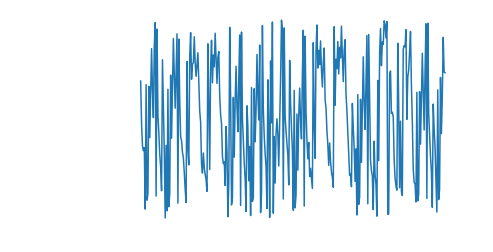

In [35]:
# now, display the predictions
table_with_predictions = preprocessed_inputs.cbind(preds)
table_with_predictions.show()

table = np.transpose(np.array(table_with_predictions.as_data_frame(use_pandas=False, header=False)))
y = table[13] # predictions
table2 = np.transpose(np.array(raw_inputs.as_data_frame(use_pandas=False, header=False)))
x = table2[0]


# plot first 2 weeks of predictions
plt.plot(x[0:336], y[0:336])
plt.axis('off')
plt.show()
